# Data Synthesis

The most easist way of reducing a dataframe dimension is dropping a variable. 

In [1]:
from sklearn.datasets import make_regression, make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lets make a regression data
variable, target = make_regression(
n_samples = 1000,
n_features = 10,
random_state = 263)

In [2]:
# Variables
X = pd.DataFrame(variable, columns=["col_name "+ str(i) for i in range(variable.shape[1])])

In [3]:
# Target
y= pd.DataFrame(target)
y.head(4)

data_lin = pd.concat([X, y], axis=1)

In [4]:
X = X.drop('col_name 5', axis = 1)
X.shape

(1000, 9)

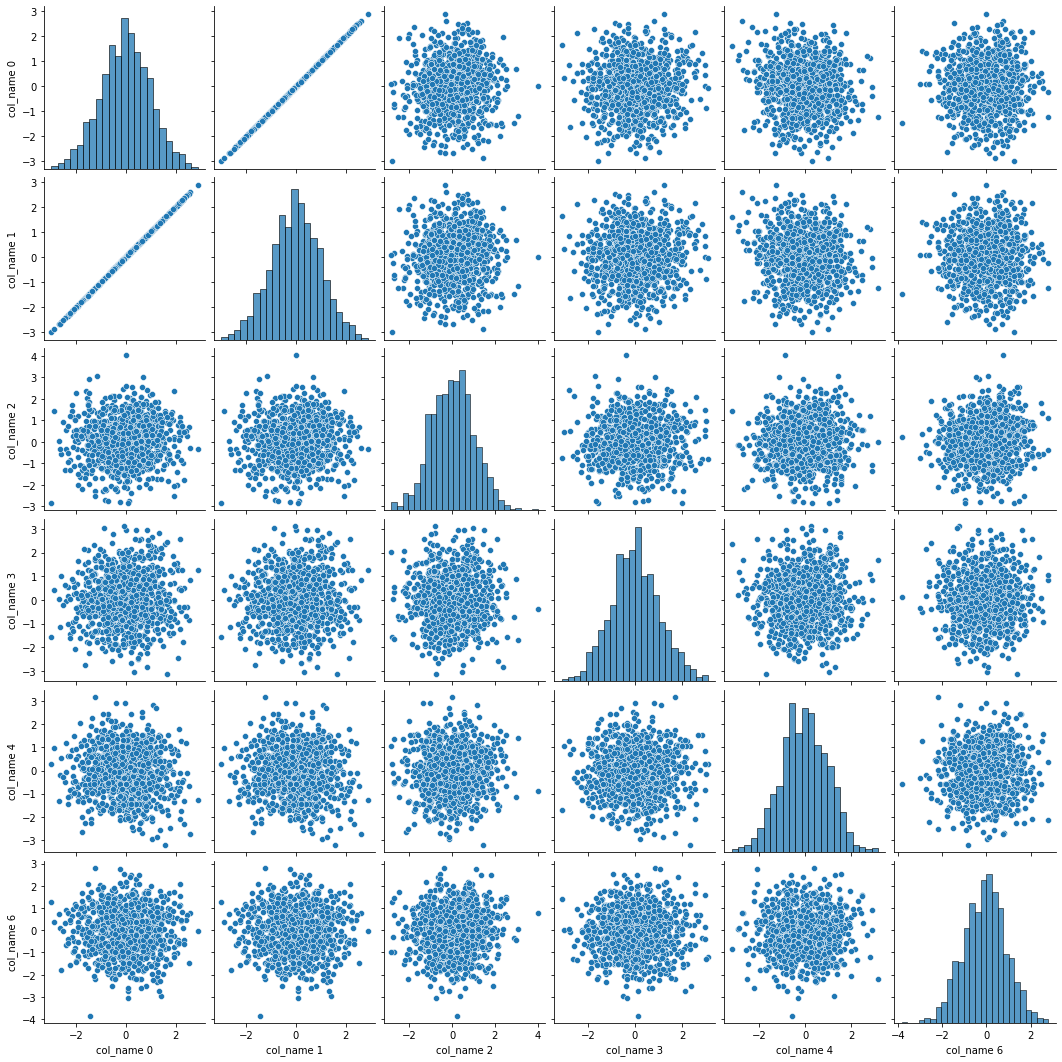

In [5]:
import seaborn as sns
X['col_name 0'] = X['col_name 1']
sns.pairplot(X.iloc[:,:6], diag_kind = 'hist')

Since the first and second columns give the same information we can drop either

## Using a Pairwise Correlation

<AxesSubplot:>

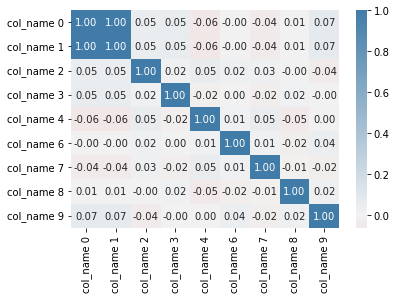

In [6]:
corr = X.corr()
cmap = sns.diverging_palette(h_neg = 10,
                             h_pos = 240,
                             as_cmap = True)

sns.heatmap(corr, center=0, cmap = cmap, annot = True, fmt = '.2f')

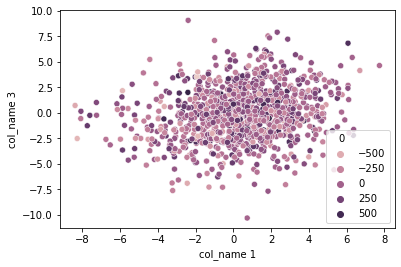

In [7]:
variables_cat, target_cat  = make_classification(
                    n_samples = 1000,
                    n_features = 50,
                    n_informative = 20,
                    n_redundant = 2,
                    n_repeated = 2,
                    n_classes = 2,
                    # Distribution of classes 45% Output1
                    # 55%> output 2        
                    weights = [.45,.55],
                    random_state = 263)

X_cat = pd.DataFrame(variables_cat, columns=["col_name "+ str(i) for i in range(variables_cat.shape[1])])
y_cat = pd.DataFrame(target)
data = pd.concat([X_cat, y_cat], axis = 1)

sns.scatterplot(x= 'col_name 1', 
               y = 'col_name 3',
            hue = 0,
               data = data)
plt.show()

##  t-SNE Visualization 

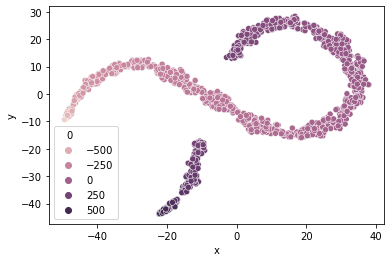

In [8]:
from sklearn.manifold import TSNE

m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(data)
tsne_features[1:4,]

data['x'] = tsne_features[:,0]
data['y'] = tsne_features[:,1]

sns.scatterplot(x= 'x', 
               y = 'y',
            hue = 0,
               data = data)
plt.show()

## Using a feature selector

We can drop variables with a small variance by setting a threshold as a benchmark

In [9]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold =8)
sel.fit(X_cat)
mask = sel.get_support()
print(mask)

reduced_data = X_cat.loc[:, mask]
print(reduced_data)

[ True False False False False False  True False False False False  True
  True False False False False False  True False False False  True False
 False False  True False False False False False False False False False
  True  True False False False False  True False False False False False
 False False]
     col_name 0  col_name 6  col_name 11  col_name 12  col_name 18  \
0      0.341500   -2.570481     1.825968    -0.317306    -0.317306   
1      7.950328  -10.511593     2.565336    -1.202353    -1.202353   
2     -0.783206   -0.191958    -0.787823     0.207255     0.207255   
3      2.580277    1.014880     5.822015     1.220420     1.220420   
4      1.524572   -0.853731    -0.184356     0.540296     0.540296   
..          ...         ...          ...          ...          ...   
995    2.052235   -2.810279     1.834000    -4.098705    -4.098705   
996    3.109233    1.998776     4.195134    -0.693222    -0.693222   
997   -2.385219    1.001843     0.057639    -3.300915    -3.3009

## Recursive Feature selection

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.2, 
                                                    random_state= 263)

ln = LinearRegression()
ln.fit(X_train, y_train)
y_pred_ln = ln.predict(X_test)

ln_mse = mean_squared_error(y_test, y_pred_ln)
print('The MSE for the Linear Regression is {}'.format(ln_mse))


# Linear Regression Recursive feture selection

ln_rfe = RFE(estimator = ln,
            n_features_to_select = 5,
            verbose=1)

ln_rfe.fit(X_train, y_train)
y_pred_rfe = ln_rfe.predict(X_test)

#X.columns[rfe.support_]


rfe_mse = mean_squared_error(y_test, y_pred_rfe)
print('The MSE for the LR RFE is {}'.format(rfe_mse))

# LASSO RFE
lasso = Lasso()

lass_rfe = RFE(estimator = lasso,
            n_features_to_select = 5,
            verbose=1)

lass_rfe.fit(X_train, y_train)
y_pred_rfe_las = lass_rfe.predict(X_test)

#X.columns[rfe.support_]


las_rfe_mse = mean_squared_error(y_test, y_pred_rfe_las)
print('The MSE for the Lasso RFE is {}'.format(las_rfe_mse))

The MSE for the Linear Regression is 5171.975609525568
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
The MSE for the LR RFE is 12106.015515758954
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
The MSE for the Lasso RFE is 12084.24522578829


## Combining Feature selection

In [11]:
lr_mask = ln_rfe.support_
lass_mask = lass_rfe.support_

votes = np.sum([lr_mask, lass_mask], axis=0)
print(votes)
mask = votes>= 2
reduced_X = X.loc[:, mask]
reduced_X.shape

[1 1 2 0 0 0 2 2 2]


(1000, 4)

In [12]:
reduced_X.head()

,col_name 2,col_name 7,col_name 8,col_name 9
0,-0.821256,-1.640529,-0.054683,0.796748
1,1.644618,0.204746,-1.678482,-1.584264
2,1.780150,0.304519,-0.136759,1.098535
3,-1.357473,-0.062200,-0.959332,-2.386220
4,-2.004558,-0.895247,-0.177516,1.161866
